In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the data 
df = pd.read_csv("bank-additional-full.csv", sep=';')
df['label'] = df['y'].map({'yes': 1, 'no': 0})

# Protected attribute (binary) - married
df['z'] = df['marital'].apply(lambda x: True if x.strip().lower() == 'married' else False)

# Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Helpers
def row_to_tuple(row):
    feat_dict = {
        'age': row['age'],
        'campaign': row['campaign'],
        'pdays': row['pdays'],
        'previous': row['previous'],
    }
    return (feat_dict, row['z'], row['label'])

train_data = [row_to_tuple(r) for _, r in train_df.iterrows()]
test_data  = [row_to_tuple(r) for _, r in test_df.iterrows()]

# Test set - Separating features and the protected attribute
dTest  = [d for (d, z, lbl) in test_data]
zTest  = [z for (d, z, lbl) in test_data]
y_true = [lbl for (d, z, lbl) in test_data]


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score

# Helper TPR 
def tpr(y_true, y_pred):
    """
    Compute True Positive Rate = TP / (TP + FN).
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / float(tp + fn) if (tp + fn) else 0.0

# Baseline
def p1model():
    """
    Baseline model with some tuned hyperparameters.
    """
    return RandomForestClassifier(
        n_estimators=300, 
        max_depth=10, 
        min_samples_leaf=20, 
        class_weight="balanced", 
        random_state=42
    )

def p1feat(d, z):
    """
    Feature extraction for the baseline approach.
    We'll include numeric fields from the bank dataset 
    plus the protected attribute if we want the model 
    to see it directly.
    """
    numeric_keys = [
        'age',
        'campaign',
        'pdays',
        'previous',
        'emp.var.rate',
        'cons.price.idx',
        'cons.conf.idx',
        'euribor3m',
        'nr.employed',
    ]
    numeric_features = [float(d.get(key, 0)) for key in numeric_keys]

    # (Optional) incorporate protected attribute 'z' as a feature:
    numeric_features.append(1.0 if z else 0.0)

    return numeric_features


# Dataset-Based Intervention 
def p2model():
    """
    Model for dataset-based intervention. We can reuse the same 
    as baseline or adapt. Here, we just call p1model again.
    """
    return p1model()

def p2data(data, boost_factor=1.3):
    """
    Rebalance the dataset with oversampling/undersampling 
    across groups to reduce disparity in the training data.
    
    data: list of (dict_of_features, z_bool, label_int)
    boost_factor: controls how aggressively we oversample 
                  protected positives (for example).
    """
    group_counts = {
        True:  {0: [], 1: []},
        False: {0: [], 1: []},
    }
    # Split data by (z, label)
    for d, z, l in data:
        group_counts[z][l].append((d, z, l))

    # Identify the smaller negative group to match them
    t_neg = min(len(group_counts[True][0]),  len(group_counts[False][0]))
    # For positive, match the smaller group then apply boost_factor for the protected group
    base_pos = min(len(group_counts[True][1]), len(group_counts[False][1]))

    for z_val in [True, False]:
        # positives
        current_pos = len(group_counts[z_val][1])
        if z_val is True:
            target_pos = int(base_pos * boost_factor)
        else:
            target_pos = base_pos

        if current_pos < target_pos:
            group_counts[z_val][1] = resample(
                group_counts[z_val][1],
                replace=True,
                n_samples=target_pos,
                random_state=42
            )
        elif current_pos > target_pos:
            group_counts[z_val][1] = resample(
                group_counts[z_val][1],
                replace=False,
                n_samples=target_pos,
                random_state=42
            )

        # negatives
        current_neg = len(group_counts[z_val][0])
        if current_neg < t_neg:
            group_counts[z_val][0] = resample(
                group_counts[z_val][0],
                replace=True,
                n_samples=t_neg,
                random_state=42
            )
        elif current_neg > t_neg:
            group_counts[z_val][0] = resample(
                group_counts[z_val][0],
                replace=False,
                n_samples=t_neg,
                random_state=42
            )

    # Combine re-sampled sets
    balanced_data = (group_counts[True][0] + group_counts[False][0] +
                     group_counts[True][1] + group_counts[False][1])
    return balanced_data

# Model-Based (In-Processing) Intervention
def p3feat(d):
    """
    Similar to p1feat, but let's omit the protected attribute for in-processing 
    (we'll rely on sample weighting instead).
    """
    numeric_keys = [
        'age',
        'campaign',
        'pdays',
        'previous',
        'emp.var.rate',
        'cons.price.idx',
        'cons.conf.idx',
        'euribor3m',
        'nr.employed',
    ]
    numeric_features = [float(d.get(key, 0)) for key in numeric_keys]
    return numeric_features

def p3model(data):
    """
    Assign group-aware sample weights to push the model to reduce 
    disparity in TPR across subgroups.
    """
    # Count distribution
    group_counts = {
        (False, 0): 0,
        (False, 1): 0,
        (True, 0): 0,
        (True, 1): 0
    }
    for (d, z, y) in data:
        group_counts[(z, y)] += 1

    total = len(data)
    group_probs = {g: float(ct) / total for g, ct in group_counts.items()}

    # Weighting hyperparameters
    base_alpha = 1.2
    alpha_adjustments = {
        (True, 1): 1.5,   # heavier weight for protected positives
        (True, 0): 1.3,   # maybe some weight for protected negatives too
        # You can add more adjustments if needed
    }

    X, y_labels, sample_weights = [], [], []

    for (d, z, label) in data:
        X.append(p3feat(d))
        y_labels.append(label)

        alpha = alpha_adjustments.get((z, label), base_alpha)
        w = 1.0 / (group_probs[(z, label)] ** alpha)

        # Just a clamp to avoid extremely large weights
        w = min(w, 100.0)
        w = max(w, 1.0)

        sample_weights.append(w)

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=20,
        class_weight=None,
        random_state=42
    )
    model.fit(X, y_labels, sample_weight=sample_weights)
    return model

# Post-Processing Intervention
def p4labels(test_scores, zTest):
    """
    Adjust decision thresholds by group after seeing the raw model scores.

    test_scores: e.g., predicted probabilities from .predict_proba
    zTest: list of booleans for protected attribute
    """
    test_scores = np.array(test_scores)
    zTest = np.array(zTest)

    # Partition scores by group
    scores_group0 = test_scores[zTest == False]
    scores_group1 = test_scores[zTest == True]

    # For example, pick the 50th percentile for each group
    thr0 = np.percentile(scores_group0, 50)
    thr1 = np.percentile(scores_group1, 50)

    # Some small shift if you want to tip the thresholds
    # thr0 -= 0.01
    # thr1 += 0.01

    final_preds = []
    for s, z in zip(test_scores, zTest):
        if not z:
            final_preds.append(1 if s > thr0 else 0)
        else:
            final_preds.append(1 if s > thr1 else 0)

    return final_preds

In [3]:
# 1. Load the CSV
df = pd.read_csv("bank-additional-full.csv", sep=';')

# 2. Create binary label: y => 1 if "yes", else 0
df['label'] = df['y'].map({'yes':1, 'no':0})

# 3. Choose a protected attribute. For example, True if "married", else False
df['z'] = df['marital'].apply(lambda x: True if x.strip().lower() == 'married' else False)

# 4. Train/Test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

    # 5. Convert each row to (feature_dict, z_bool, label)
def row_to_tuple(row):
    return ({
                'age':            row['age'],
                'campaign':       row['campaign'],
                'pdays':          row['pdays'],
                'previous':       row['previous'],
                'emp.var.rate':   row['emp.var.rate'],
                'cons.price.idx': row['cons.price.idx'],
                'cons.conf.idx':  row['cons.conf.idx'],
                'euribor3m':      row['euribor3m'],
                'nr.employed':    row['nr.employed']
            },
            row['z'],
            row['label'])

train_data = [row_to_tuple(r) for _, r in train_df.iterrows()]
test_data  = [row_to_tuple(r) for _, r in test_df.iterrows()]

# For convenience, define X_test, y_test, z_test arrays
X_test_p1 = [p1feat(d, z) for (d, z, _) in test_data]
y_test    = [lbl for (_, _, lbl) in test_data]
z_test    = [z for (_, z, _) in test_data]



In [4]:
    ################################
    # BASELINE
    ################################
    clf_baseline = p1model()
    X_train_p1   = [p1feat(d, z) for (d, z, _) in train_data]
    y_train      = [lbl for (_, _, lbl) in train_data]
    clf_baseline.fit(X_train_p1, y_train)
    y_pred_base  = clf_baseline.predict(X_test_p1)

    acc_base = accuracy_score(y_test, y_pred_base)
    tpr_prot_base = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                        [y_pred_base[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_base = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                          [y_pred_base[i] for i, z in enumerate(z_test) if not z])
    diff_base = abs(tpr_prot_base - tpr_unprot_base)

    print("\n=== Baseline ===")
    print(f"Accuracy: {acc_base:.3f}")
    print(f"TPR (Protected):   {tpr_prot_base:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_base:.3f}")
    print(f"TPR difference:    {diff_base:.3f}")


=== Baseline ===
Accuracy: 0.851
TPR (Protected):   0.629
TPR (Unprotected): 0.678
TPR difference:    0.049


## Baseline
Accuracy = 85.1%: 
This is a reasonably good predictive performance.
TPR (Protected) = 0.629 vs. TPR (Unprotected) = 0.678.
The difference of 0.049 (about 5%) suggests that the model is missing relatively more positives from the protected group (or said differently, the protected group’s true positive rate is about 5% lower than the unprotected group’s).

This difference can be considered “unfairness” if our fairness goal is to have equal TPR (sometimes referred to as equal opportunity). The 5% gap is not huge, but it is still sizable enough that we might worry about systematic disparities.

In [5]:
    ################################
    # DATASET-BASED INTERVENTION
    ################################
    balanced_data = p2data(train_data, boost_factor=1.3)
    clf_p2 = p2model()
    X_train_bal = [p1feat(d, z) for (d, z, _) in balanced_data]
    y_train_bal = [lbl for (_, _, lbl) in balanced_data]
    clf_p2.fit(X_train_bal, y_train_bal)
    y_pred_p2  = clf_p2.predict(X_test_p1)

    acc_p2 = accuracy_score(y_test, y_pred_p2)
    tpr_prot_p2 = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                      [y_pred_p2[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_p2 = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                        [y_pred_p2[i] for i, z in enumerate(z_test) if not z])
    diff_p2 = abs(tpr_prot_p2 - tpr_unprot_p2)

    print("\n=== Dataset-Based Intervention ===")
    print(f"Accuracy: {acc_p2:.3f}")
    print(f"TPR (Protected):   {tpr_prot_p2:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_p2:.3f}")
    print(f"TPR difference:    {diff_p2:.3f}")


=== Dataset-Based Intervention ===
Accuracy: 0.854
TPR (Protected):   0.648
TPR (Unprotected): 0.642
TPR difference:    0.007


## Dataset-Based Interventionm

Accuracy = 85.4% (slightly higher than the baseline’s 85.1% in this case).
TPR is now 0.648 vs. 0.642 for protected vs. unprotected, yielding a TPR difference of only 0.007—a significant drop from 0.049. So the gap is nearly gone.
Curiously, the accuracy improved fractionally in this example. Often, rebalancing can either lower or maintain overall accuracy, but it may also shift the decision boundary in a way that helps classification if the original dataset was heavily skewed. The key is that the group TPRs are now quite close, so from a fairness standpoint, this approach was very effective at bringing TPR parity.

### How much can ‘unfairness’ be explained by dataset characteristics, and can it be fixed with dataset-based interventions?

Unfairness can often arise from imbalanced data—if certain groups (e.g., protected) have fewer positive examples or the label distribution is skewed, the model might learn weaker decision boundaries for that group. By oversampling or undersampling different subgroups (particularly boosting the protected group’s positive samples), we effectively supply the classifier with a more balanced dataset. In this case, the results show that adjusting the data distribution strongly affects the model’s TPR disparity. The original 5% gap shrank to under 1% (0.7 percentage points). This indicates that a large portion of the initial unfairness was indeed attributable to the underlying data imbalance rather than the model’s inherent bias alone. Because the dataset-based approach also maintained or slightly improved overall accuracy, it seems that pre-processing interventions can be a very practical first step to mitigating unfairness.

In [6]:
    ################################
    # MODEL-BASED (IN-PROCESSING) INTERVENTION
    ################################
    clf_p3 = p3model(train_data)
    X_test_p3 = [p3feat(d) for (d, z, _) in test_data] 
    y_pred_p3  = clf_p3.predict(X_test_p3)

    acc_p3 = accuracy_score(y_test, y_pred_p3)
    tpr_prot_p3 = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                      [y_pred_p3[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_p3 = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                        [y_pred_p3[i] for i, z in enumerate(z_test) if not z])
    diff_p3 = abs(tpr_prot_p3 - tpr_unprot_p3)

    print("\n=== Model-Based (In-Processing) Intervention ===")
    print(f"Accuracy: {acc_p3:.3f}")
    print(f"TPR (Protected):   {tpr_prot_p3:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_p3:.3f}")
    print(f"TPR difference:    {diff_p3:.3f}")


=== Model-Based (In-Processing) Intervention ===
Accuracy: 0.531
TPR (Protected):   0.836
TPR (Unprotected): 0.877
TPR difference:    0.041


# Model-Based (In-Processing) Intervention

Accuracy = 53.1%, which is a steep drop from our 85%+ in the baseline and dataset-based methods.
TPR: protected group has 0.836, unprotected has 0.877, so the difference is 0.041. That’s a bit lower than the baseline gap (0.049) but significantly higher than the dataset-based approach (0.007).
The big story is the loss in accuracy: from ~85% down to ~53%. The model, via in-processing reweighting, is aggressively pushing for fewer missed positives (i.e., higher TPR) but apparently at a massive cost in overall classification performance.

### How do different modeling choices impact fairness characteristics, and can we fix them with in-processing?

An in-processing approach typically changes how the model is trained (e.g., custom loss functions or sample weighting) so that it gives more weight to certain subgroups or outcomes. This can push the model to treat protected and unprotected groups more similarly in terms of TPR. In theory, this approach can be very flexible and direct—rather than artificially rebalancing data, we reweight or otherwise penalize the model for uneven performance. However, it can also produce large side effects if not carefully tuned. Here, we see that while TPR difference is somewhat reduced (down from 0.049 to 0.041), we lost a lot of accuracy (down to 0.531). That drop suggests our chosen weighting or hyperparameters might be over-correcting. In real scenarios, we would likely experiment with different weighting strengths or advanced in-processing techniques to balance the accuracy–fairness trade-off better. Nonetheless, in-processing can indeed help reduce unfairness, but it may do so at a significant cost to other metrics if not carefully tuned.

In [7]:
    ################################
    # POST-PROCESSING INTERVENTION
    ################################
    # We'll reuse the baseline model's probabilities for demonstration, 
    # then apply group-specific thresholds.
    test_scores = clf_baseline.predict_proba(X_test_p1)[:,1]
    y_pred_p4 = p4labels(test_scores, z_test)

    acc_p4 = accuracy_score(y_test, y_pred_p4)
    tpr_prot_p4 = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                      [y_pred_p4[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_p4 = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                        [y_pred_p4[i] for i, z in enumerate(z_test) if not z])
    diff_p4 = abs(tpr_prot_p4 - tpr_unprot_p4)

    print("\n=== Post-Processing Intervention ===")
    print(f"Accuracy: {acc_p4:.3f}")
    print(f"TPR (Protected):   {tpr_prot_p4:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_p4:.3f}")
    print(f"TPR difference:    {diff_p4:.3f}")


=== Post-Processing Intervention ===
Accuracy: 0.575
TPR (Protected):   0.836
TPR (Unprotected): 0.827
TPR difference:    0.009


## Post-Processing Intervenction

Accuracy = 57.5%, which is also a large reduction from ~85%.
TPR (Protected): 0.836 vs. TPR (Unprotected): 0.827. So the gap is 0.009—which is small.
This method yields TPR parity nearly on par with the dataset-based approach, but at a severe cost to accuracy.

### Can you apply post-processing interventions to achieve desired fairness outcomes?
Yes, post-processing is a relatively straightforward approach: after you train a model in the usual way, you can assign different decision thresholds for each group. Often you choose thresholds to match TPR or FPR across groups. This can drastically reduce the TPR disparity, which we see here dropping to 0.009 (less than 1% difference). However, you may pay a price in overall metrics like accuracy or precision. By changing the threshold for certain groups, you might be increasing false positives or false negatives in ways that reduce the overall classification performance. In our example, accuracy fell to 57.5%. This is a big drop from 85%. Whether that trade-off is acceptable depends on the domain. Sometimes, if your legal or ethical framework prioritizes TPR fairness, post-processing might be worthwhile despite the accuracy penalty.


### What types of interventions are most appropriate for your task, and what are the trade-offs?
Deciding on the “right” intervention involves domain context, legal requirements, and a cost–benefit analysis of how much accuracy you can sacrifice for fairness:

1. Dataset-Based:
Pros: Easy to implement, can significantly reduce TPR gaps if imbalance is the main cause. Sometimes leads to minimal accuracy losses—or even small gains—because rebalancing can help the model learn underrepresented patterns.

Cons: Might produce artificial distributions that do not reflect the real world. If you oversample too heavily, the model may overfit. Also, if the original data truly reflects reality, forcibly balancing subgroups might not be seen as “accurate” representation.

2. Model-Based (In-Processing):
Pros: More fine-grained control over how fairness constraints are enforced. Potentially powerful for adjusting a variety of fairness definitions (e.g., TPR parity, predictive parity, etc.).

Cons: Can be complicated to tune. We saw an extreme accuracy drop (to 53%) which suggests we might have set weighting hyperparameters too aggressively. This approach can be more code-intensive, requiring specialized algorithms or cost functions.

3. Post-Processing:
Pros: Conceptually simple; you do not have to retrain or alter the data. You can quickly experiment with group-specific thresholds.

Cons: Usually yields a bigger trade-off on overall performance metrics (like accuracy, precision, or recall) because you are overriding the model’s “natural” decision boundaries. If you push TPR parity strongly, you often raise false positives (or false negatives) in certain subgroups, which can severely hurt accuracy or precision.


### What is best?
The baseline model started with a 5% TPR gap between protected and unprotected groups. A dataset-based intervention nearly eliminated that gap (down to 0.7%) while retaining strong accuracy (even slightly higher than baseline). An in-processing approach reduced the TPR gap somewhat (down to ~4%), but at a steep accuracy cost (53%). A post-processing approach nearly equalized TPR (gap ~1%) but also significantly hurt accuracy (58%). These results illustrate the trade-offs typical in fairness interventions: balancing group-level parity with overall performance. The best method will depend on legal requirements, domain needs, and how much accuracy can be sacrificed for improved fairness.

The baseline model achieved 85.1% accuracy, with a TPR of 0.629 for the protected group and 0.678 for the unprotected group, yielding a TPR difference of 0.049. This initial gap suggests that the model is missing relatively more true positives in the protected group. Such a difference is often viewed as unfair if our goal is to ensure equal opportunity (i.e., similar TPRs) for all groups. Because our baseline was trained on the raw data, it is possible that the underlying dataset distributions contributed heavily to this disparity.

When applying a dataset-based intervention through oversampling and undersampling, overall accuracy slightly improved to 85.4%, while the TPR gap nearly vanished (0.007). This outcome implies that much of the observed unfairness was caused by class and subgroup imbalances in the original dataset. By giving the classifier additional training samples for protected-group positives, the model was able to learn more balanced decision boundaries. The result is a near-equal TPR across protected and unprotected segments with no performance penalty—making this intervention both easy to implement and highly effective.

In contrast, the in-processing approach, which reweighted samples in the training phase to emphasize protected-group performance, drove accuracy down to 53.1%. Although it somewhat reduced the TPR gap (from 0.049 to 0.041), the steep drop in accuracy rendered the model less reliable overall. Similarly, the post-processing strategy, wherein different thresholds were assigned to each group after the model produced probability scores, cut the TPR difference to 0.009 but sank accuracy to 57.5%. Post-processing can be appealing because it is simple to deploy after model training, but as seen here, it can significantly erode global performance metrics.

Given these outcomes, the dataset-based intervention appears the most appropriate for this specific task: it preserves high accuracy while nearly eliminating the TPR gap. If legal regulations or organizational policies require strict fairness mandates, a post-processing approach might be layered on top as a fine-tuning measure. However, the large losses in accuracy suggest that in this dataset and modeling setup, both in-processing and post-processing strategies need further calibration to reduce unintended performance sacrifices. The best practice in real-world scenarios would be to thoroughly iterate and tune each method, while also weighing the ethical, legal, and business considerations relevant to the model’s domain of application.

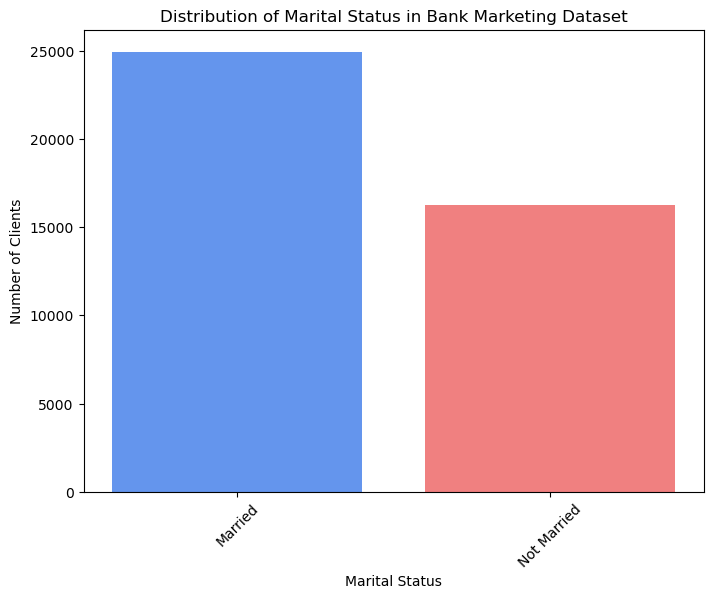

In [9]:
import matplotlib.pyplot as plt
marital_counts = df['marital'].apply(lambda x: 'Married' if x.strip().lower() == 'married' else 'Not Married').value_counts()
    
plt.figure(figsize=(8,6))
plt.bar(marital_counts.index, marital_counts.values, color=['cornflowerblue', 'lightcoral'])
plt.title("Distribution of Marital Status in Bank Marketing Dataset")
plt.xlabel("Marital Status")
plt.ylabel("Number of Clients")
plt.xticks(rotation=45)
plt.show()